# Modeling and Evaluation

In [1]:
### ALL THE IMPORTS NEEDED FOR THIS PHASE

# Data wrangling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Clustering algorithms
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

# Map visualization
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import CARTODBPOSITRON, get_provider

# imports for small tasks
import math
from joblib import load
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, silhouette_samples

import warnings
warnings.filterwarnings('ignore')

c:\users\imed\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
uber_sample_transformed_df = pd.read_csv("uber_sample_transformed.csv")

In [3]:
uber_sample_transformed_df.head()

,latitude,longitude,time_of_day,day_of_week,long_weekend,period_of_day
0,0.346431,0.026384,-2.462367,0.622075,-0.710566,-2.161374
1,-0.517802,-0.399180,-2.462367,0.622075,-0.710566,-2.161374
2,0.647519,0.096661,-2.462367,0.622075,-0.710566,-2.161374
3,0.078797,-0.151260,-2.462367,0.622075,-0.710566,-2.161374
4,-0.283623,-0.654909,-2.462367,0.622075,-0.710566,-2.161374


In [4]:
uber_sample_transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28229 entries, 0 to 28228
Data columns (total 6 columns):
latitude         28229 non-null float64
longitude        28229 non-null float64
time_of_day      28229 non-null float64
day_of_week      28229 non-null float64
long_weekend     28229 non-null float64
period_of_day    28229 non-null float64
dtypes: float64(6)
memory usage: 1.3 MB


## Clustering
### KMeans
#### Determining the number of clusters

First, we need to choose the number of clusters. To do this, there are two methods to identify the right number.

##### Elbow Method

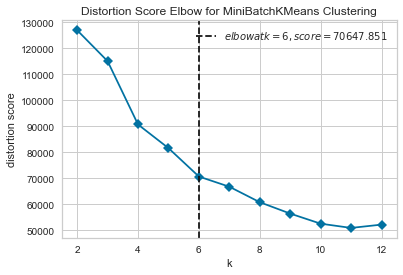

In [5]:
kmeans_estimator = MiniBatchKMeans(max_iter=200, n_init=5, random_state=42)
visualizer = KElbowVisualizer(kmeans_estimator, k=(2,13), timings=False)
visualizer.fit(uber_sample_transformed_df)
visualizer.show()

Although the elbow is not clearly visible on the graph, we can say that the optimal clustering should contain between 4 and 8 clusters. 

##### Silhouette Method

For n_clusters = 4 The average silhouette_score is : 0.3203771115915218
For n_clusters = 5 The average silhouette_score is : 0.24697530048907526
For n_clusters = 6 The average silhouette_score is : 0.3747808022504416
For n_clusters = 7 The average silhouette_score is : 0.3737470480701296
For n_clusters = 8 The average silhouette_score is : 0.28952823626555063


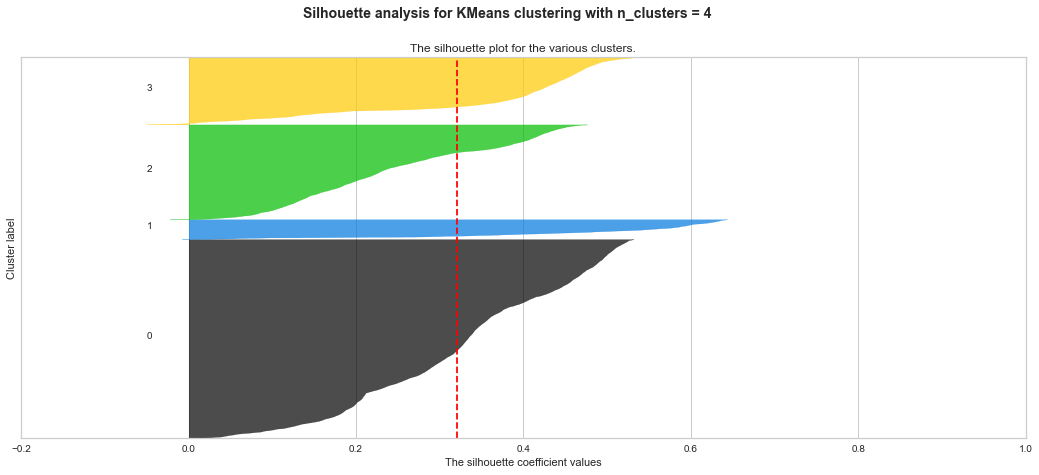

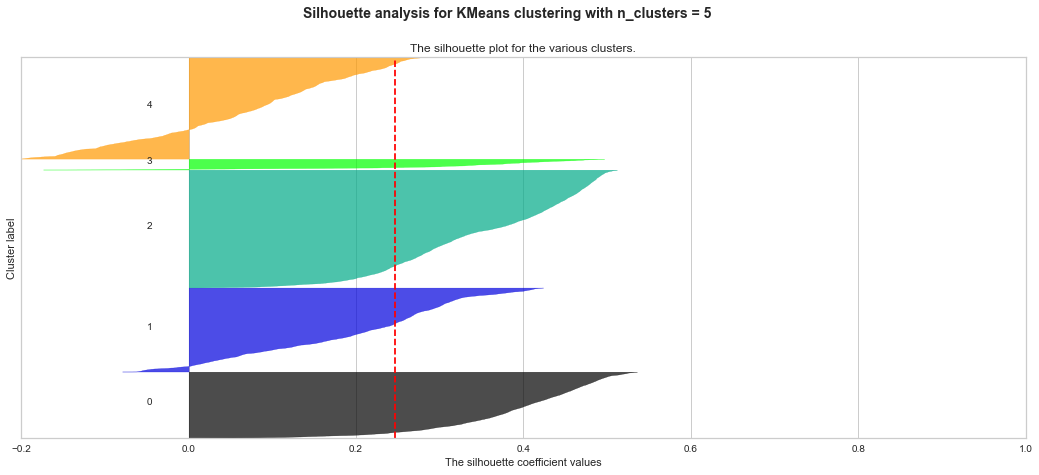

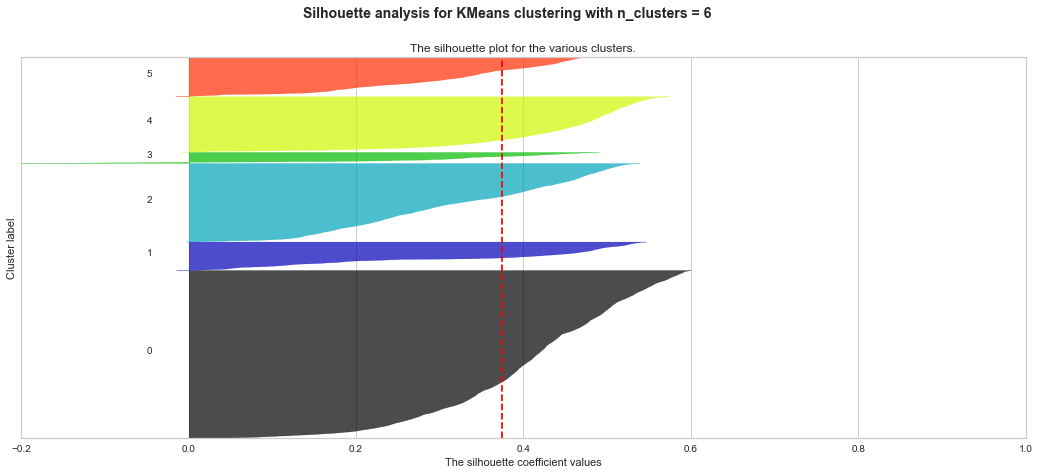

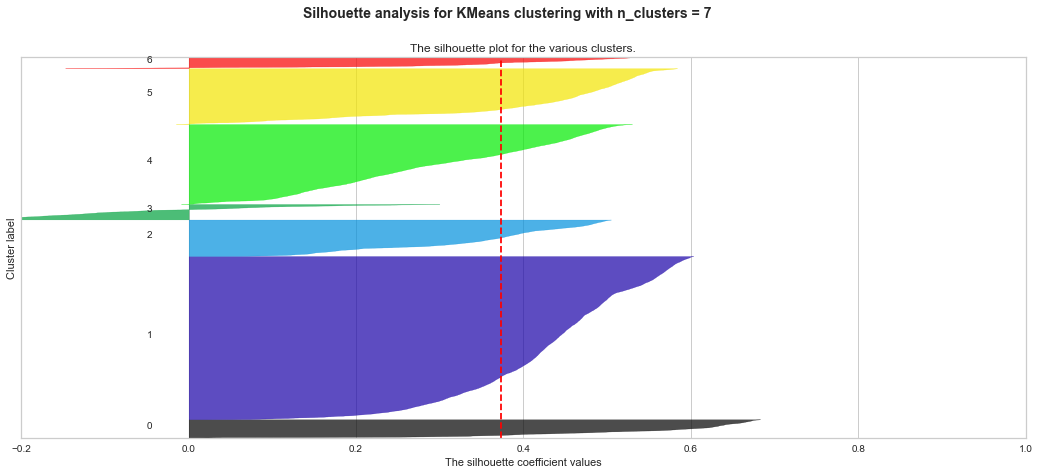

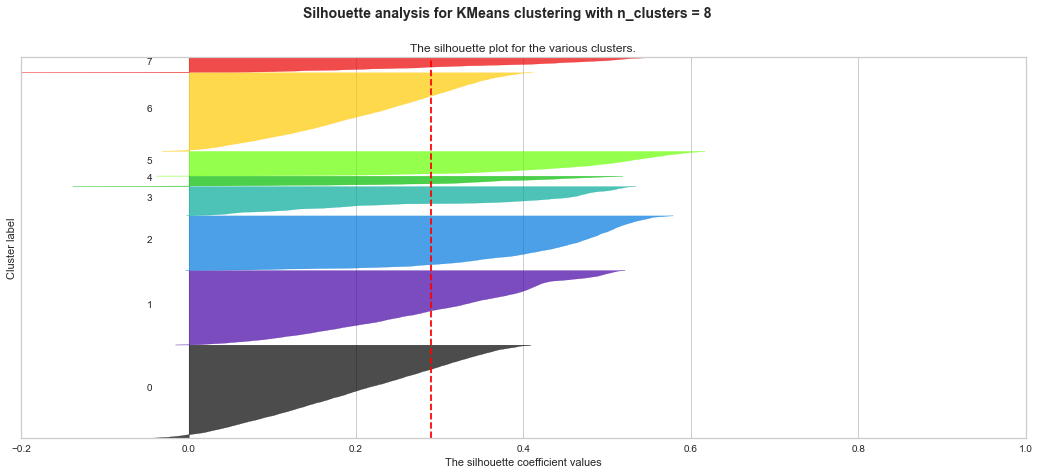

In [6]:
X = uber_sample_transformed_df.values
range_n_clusters = [4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = MiniBatchKMeans(n_clusters=n_clusters, max_iter=200, n_init=5, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

* When the number of clusters is 7 or 8, we see that many observations have high negative scores. For example, if we assume that there are 7 clusters, classes 3 and 6 group together a number of poorly classified individuals with a score below -0.1. We will not retain these breakdowns.
* In the 6-class partitioning, class 3, the smallest in number of observations, has a large number (given its size) of misclassified observations with a high negative score. It is better to clump this cluster in another
* In the grouping into 5 classes, there are outliers in 3 of them. For class 1, the scores of the misclassified individuals are low. On the other hand, the outliers in classes 3 and 4 are numerous in proportion and have a very high negative score (very close to -0.2)
* With regard to the division into four classes, three clusters out of four show outliers, but this concerns very few individuals. The negative scores of the latter are quite low.

#### Training

We decide to consider a grouping into 4 clusters to train our KMeans model.

In [7]:
kmeans_clustering = MiniBatchKMeans(n_clusters=4, max_iter=200, n_init=5, random_state=23)
kmeans_labels = kmeans_clustering.fit_predict(uber_sample_transformed_df)

In [8]:
kmeans_labels

array([1, 1, 1, ..., 2, 2, 2])

In [9]:
np.bincount(kmeans_labels)

array([ 4968,  8113, 14326,   822], dtype=int64)

In [10]:
kmeans_clustering.cluster_centers_

array([[-0.05305303, -0.07828155,  0.39658405,  1.37281038,  1.4052151 ,
         0.40160191],
       [ 0.03237172, -0.09860836, -1.29050497, -0.14591709, -0.10736577,
        -1.32791342],
       [ 0.10745951, -0.14308723,  0.59583996, -0.40152946, -0.44169502,
         0.61436631],
       [-1.69885156,  4.14523558,  0.03390365,  0.01847914,  0.11687012,
         0.02202938]])

In [11]:
uber_sample_transformed_df.columns

Index(['latitude', 'longitude', 'time_of_day', 'day_of_week', 'long_weekend',
       'period_of_day'],
      dtype='object')

### DBSCAN

* We need to determine two parameters in order to train a DBSCAN model: 
    - __eps__, the maximum distance between two individuals to be considered as belonging to the neighbourhood of either of these points
    - __min_samples__, the minimum number of observations to be gathered around a point in order for this point to be considered a core point
* Furthermore, we will use the l1 distance, or Manhattan distance, rather than the Euclidean distance, or distance as the crow flies. This distance corresponds well to the topology of the city in which the streets form a grid.

#### Neighbourhood distance

In [12]:
uber_sample_neighbor = NearestNeighbors(n_neighbors=2, metric='manhattan')
closest_distance, closest_sample = uber_sample_neighbor.fit(uber_sample_transformed_df).kneighbors(uber_sample_transformed_df)

In [13]:
# Array representing the distance to the nearest point, the first column is null: distance between the point and itself
closest_distance.shape, closest_distance

((28229, 2), array([[0.        , 0.01505566],
        [0.        , 0.18987984],
        [0.        , 0.12047066],
        ...,
        [0.        , 0.03485764],
        [0.        , 0.17679537],
        [0.        , 0.1561259 ]]))

In [14]:
# Indices of closest observations in the data sample
closest_sample.shape, closest_sample

((28229, 2), array([[    0,    15],
        [    1,    33],
        [    2,    27],
        ...,
        [28226, 28203],
        [28227, 28215],
        [28228, 28225]], dtype=int64))

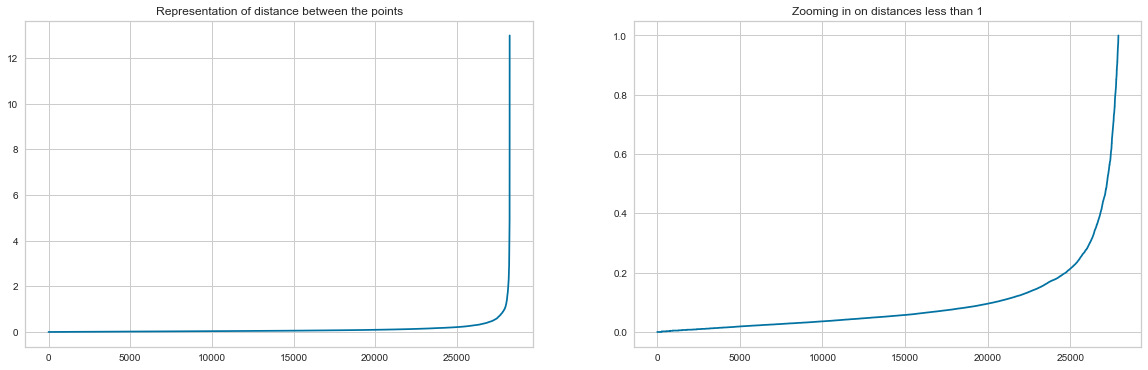

In [15]:
closest_distance = np.sort(closest_distance, axis=0)

plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.plot(closest_distance[:, 1])
plt.title("Representation of distance between the points")

plt.subplot(122)
plt.plot(closest_distance[closest_distance[:, 1] <= 1, 1])
plt.title("Zooming in on distances less than 1")

plt.show()

* The optimum value for __eps__ will be the maximum point of curvature.
* We will take 0.2 as the value for the __eps__ parameter of the DBSCAN algorithm.

#### Minimum number of observations

In [16]:
def train_dbscan(n_samples, distance_metric='euclidean'):
    dbscan_clustering = DBSCAN(eps=0.2, min_samples=n_samples, metric=distance_metric)
    dbscan_labels = dbscan_clustering.fit_predict(uber_sample_transformed_df)
    return pd.Series(dbscan_labels).value_counts()

In [17]:
train_dbscan(85)

-1     24359
 10      625
 9       593
 7       490
 6       467
 8       422
 5       307
 0       281
 4       198
 1       194
 2       184
 3       109
dtype: int64

In [18]:
train_dbscan(85, 'manhattan')

-1    28229
dtype: int64

In [19]:
train_dbscan(80)

-1     24068
 10      689
 9       628
 7       501
 6       484
 8       437
 5       326
 0       307
 4       254
 1       213
 2       211
 3       111
dtype: int64

In [20]:
train_dbscan(80, 'manhattan')

-1    28067
 1       82
 0       80
dtype: int64

In [21]:
train_dbscan(75)

-1     23495
 12      710
 11      653
 9       543
 7       504
 10      448
 6       386
 0       325
 1       313
 4       289
 2       227
 8       141
 3       118
 5        77
dtype: int64

In [22]:
train_dbscan(75, 'manhattan')

-1    27853
 2      114
 0      103
 3       84
 1       75
dtype: int64

In [23]:
train_dbscan(70)

-1     22930
 12      730
 11      699
 9       566
 7       544
 10      471
 6       422
 0       355
 1       348
 4       336
 2       251
 8       211
 3       129
 13      105
 5       104
 14       28
dtype: int64

In [24]:
train_dbscan(70, 'manhattan')

-1    27631
 3      303
 0      115
 1       93
 2       87
dtype: int64

After several attempts, the algorithm still gives disappointing results: it places at least 22 000 individuals (out of a total of 28 229) in class -1, which corresponds to outliers. This number is too high.

### OPTICS

* We will use another algorithm, quite similar: OPTICS.
* Unlike DBSCAN, this algorithm keeps cluster hierarchy for a variable neighborhood radius. It is better suited for usage on large datasets than the current sklearn implementation of DBSCAN.

In [25]:
def train_optics(n_samples, distance_metric='euclidean'):
    optics_clustering = OPTICS(eps=0.2,min_samples=n_samples, metric=distance_metric)
    optics_labels = optics_clustering.fit_predict(uber_sample_transformed_df)
    return pd.Series(optics_labels).value_counts()

In [26]:
train_optics(85)

-1    25476
 2     1110
 1      650
 6      432
 7      136
 3      111
 5      106
 4      105
 0      103
dtype: int64

In [27]:
train_optics(85, 'manhattan')

-1    26642
 3      823
 2      409
 4      125
 1      117
 0      113
dtype: int64

In [28]:
train_optics(75)

-1     24453
 2      1110
 9       857
 7       432
 0       419
 8       308
 10      136
 3       135
 4       118
 5        92
 6        89
 1        80
dtype: int64

In [29]:
train_optics(75, 'manhattan')

-1    26942
 3      823
 4      144
 0      113
 2      107
 1      100
dtype: int64

In [30]:
train_optics(65)

-1     24382
 2      1110
 9       857
 7       370
 8       308
 11      302
 12      146
 4       139
 3       136
 6       111
 1       103
 0       102
 5        93
 10       70
dtype: int64

In [31]:
train_optics(65, 'manhattan')

-1    27172
 5      325
 2      149
 7      144
 4      110
 3       96
 1       87
 0       75
 6       71
dtype: int64

In [32]:
train_optics(800)

0    28229
dtype: int64

We do not obtain better results than with the DBSCAN algorithm : too many observations are classified as outliers.

## Cluster visualisation
### Coordinate conversion

In [33]:
def merc(lat_lon):
    lat = lat_lon[0]
    lon = lat_lon[1]
    r_major = 6378137.000
    
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + lat * (math.pi/180.0)/2.0)) * scale
    return [x, y]

We need the StandardScaler object created in Data Preparation phase to normalise the numerical features. We will use it to return to the original coordinates of the pickups. 

In [34]:
numerical_scaler = load("numerical_scaler.joblib")

In [35]:
numerical_scaler.mean_

array([ 40.73997354, -73.97665156,  14.4648057 ])

In [36]:
numerical_scaler.scale_

array([0.03586995, 0.05122611, 5.87435088])

In [37]:
uber_sample_df = uber_sample_transformed_df[["latitude", "longitude"]] * numerical_scaler.scale_[:-1] + numerical_scaler.mean_[:-1]

In [38]:
uber_sample_df['Coords_x'] = uber_sample_df.apply(lambda x : merc(x)[0], axis=1)
uber_sample_df['Coords_y'] = uber_sample_df.apply(lambda x: merc(x)[1], axis=1)

In [39]:
uber_sample_df.tail()

,latitude,longitude,Coords_x,Coords_y
28224,40.7483,-73.9901,-8.236540e+06,4.975287e+06
28225,40.7628,-73.9819,-8.235627e+06,4.977417e+06
28226,40.7569,-73.9900,-8.236529e+06,4.976550e+06
28227,40.7563,-74.0015,-8.237809e+06,4.976462e+06
28228,40.7677,-73.9829,-8.235739e+06,4.978138e+06


### Visualisation of pickups 

We will visualise the results given by the KMeans algorithm.

#### No matter what day of the week or time of day

In [40]:
# Colour of clusters
colormap = {-1 : 'black', 0: 'yellow', 1: 'orange', 2: 'red', 3: 'green'}

In [41]:
colors = [colormap[x] for x in kmeans_labels]

p = figure(title="Visualisation of clusters from KMeans", x_axis_type="mercator", y_axis_type="mercator")
tile_provider = get_provider(CARTODBPOSITRON)
p.add_tile(tile_provider)
p.circle(x = uber_sample_df['Coords_x'], y = uber_sample_df['Coords_y'], color=colors)

output_notebook()
show(p)

Loading BokehJS ...

* The majority of individuals are concentrated in the heart of the city, in the Manhattan area.
* There is a clear demarcation between the class 3 observations (in green) and the other observations. The samples in class 3 are located in the East of the city.
* There are two centres of concentration on the outskirts of the high concentration area (Manhattan district): the Hoboken district and Newark airport, where individuals from classes 0, 1 and 2 are found in equivalent proportions.

In [42]:
# The first two columns correspond to the latitude and longitude coordinates
cluster_centers_lat_lon_scaled = kmeans_clustering.cluster_centers_[:, :2]
cluster_centers_lat_lon = cluster_centers_lat_lon_scaled * numerical_scaler.scale_[:2] + numerical_scaler.mean_[:2]
cluster_centers_coord = np.apply_along_axis(merc, 1, cluster_centers_lat_lon)

In [43]:
p = figure(
    title="Visualisation of cluster centroids from KMeans",
    x_axis_type="mercator", 
    y_axis_type="mercator", 
    y_range=(cluster_centers_coord[:, 1].min() - 5000, cluster_centers_coord[:, 1].max() + 5000),
    x_range=(cluster_centers_coord[:, 0].min() - 5000, cluster_centers_coord[:, 0].max() + 5000)
)
p.add_tile(tile_provider)

for cluster in range(4):
    p.circle(
        x=cluster_centers_coord[cluster, 0],
        y=cluster_centers_coord[cluster, 1], 
        size=6,
        color=colormap[cluster],
        fill_alpha=0.8
    )
    
output_notebook()
show(p)

Loading BokehJS ...

* The centroids of clusters 0, 1 and 2 are located in the Manhattan district, while the centroid of cluster 3 is located near John F. Kennedy Airport.
* Specifically, the class 0, 1 and 2 centroids are located in Midtown Manhattan.
* This is consistent with the findings from the first map.

#### Depending on the day of the week and time of day

* In the Data Understanding phase, we identified 5 time slots and a difference between trips made on weekdays and weekends.
* Before looking at the clusters we have established according to each of these periods, we need to recover the two categorical features.

In [44]:
categorical_scaler = load("categorical_scaler.joblib")

In [45]:
uber_sample_transformed_df.head(3)

,latitude,longitude,time_of_day,day_of_week,long_weekend,period_of_day
0,0.346431,0.026384,-2.462367,0.622075,-0.710566,-2.161374
1,-0.517802,-0.399180,-2.462367,0.622075,-0.710566,-2.161374
2,0.647519,0.096661,-2.462367,0.622075,-0.710566,-2.161374


In [46]:
uber_sample_df = pd.merge(
    uber_sample_df, 
    pd.DataFrame(
        categorical_scaler.inverse_transform(uber_sample_transformed_df[["day_of_week", "long_weekend", "period_of_day"]])[:, 1:],
        columns=["long_weekend", "period_of_day"]
    ),
    left_index=True,
    right_index=True
)

In [47]:
uber_sample_df.head(3)

,latitude,longitude,Coords_x,Coords_y,long_weekend,period_of_day
0,40.7524,-73.9753,-8.234893e+06,4.975889e+06,0.0,4.440892e-16
1,40.7214,-73.9971,-8.237319e+06,4.971335e+06,0.0,4.440892e-16
2,40.7632,-73.9717,-8.234492e+06,4.977476e+06,0.0,4.440892e-16


In [48]:
uber_sample_df[["long_weekend", "period_of_day"]] = uber_sample_df[["long_weekend", "period_of_day"]].round().astype('int64')

In [49]:
uber_sample_df.head(3)

,latitude,longitude,Coords_x,Coords_y,long_weekend,period_of_day
0,40.7524,-73.9753,-8.234893e+06,4.975889e+06,0,0
1,40.7214,-73.9971,-8.237319e+06,4.971335e+06,0,0
2,40.7632,-73.9717,-8.234492e+06,4.977476e+06,0,0


##### From midnight to 5am

In [50]:
def visualise_clustering(title="No title", long_weekend=0, period_of_day=0):
    p = figure(
        title=title, 
        x_axis_type="mercator", 
        y_axis_type="mercator"
    )
    p.add_tile(tile_provider)

    period_indices = uber_sample_df.loc[(uber_sample_df["long_weekend"] == long_weekend) & (uber_sample_df["period_of_day"] == period_of_day), :].index

    kmeans_labels_period = kmeans_labels[period_indices]

    colors = [colormap[x] for x in kmeans_labels_period]                                                

    p.circle(
        x=uber_sample_df.loc[period_indices, 'Coords_x'],
        y=uber_sample_df.loc[period_indices, 'Coords_y'],
        color=colors
    )

    output_notebook()
    show(p)
    return kmeans_labels_period

In [51]:
kmeans_labels_night_weekdays = visualise_clustering(
    title="Visualisation of the clusters from KMeans for pickups from midnight to 5am on weekdays", 
    long_weekend=0, 
    period_of_day=0
)

Loading BokehJS ...

In [52]:
kmeans_samples_per_cluster = pd.concat(
    [pd.Series(list(colormap.values())[1:]), pd.Series(kmeans_labels).value_counts(), pd.Series(kmeans_labels_night_weekdays).value_counts()], 
    axis=1, 
).rename(columns={0 : "Cluster colour", 1 : "All week long at any time", 2 : "Night on weekdays"})
kmeans_samples_per_cluster["Ratio"] = kmeans_samples_per_cluster["Night on weekdays"] / kmeans_samples_per_cluster["All week long at any time"] * 100
kmeans_samples_per_cluster

,Cluster colour,All week long at any time,Night on weekdays,Ratio
0,yellow,4968,NaN,NaN
1,orange,8113,961.0,11.845187
2,red,14326,NaN,NaN
3,green,822,44.0,5.352798


* No individuals of classes 0 and 2 are present in the visualisation.
* We find almost 12% of the trips in cluster 3. The drivers who run these errands work in the Manhattant and Brooklyn districts, as well as in the west, in the Hoboken district.

In [53]:
kmeans_labels_night_weekend = visualise_clustering(
    title="Visualisation of the clusters from KMeans for pickups from midnight to 5am on weekend", 
    long_weekend=1, 
    period_of_day=0
)

Loading BokehJS ...

In [54]:
kmeans_samples_per_cluster = pd.concat(
    [pd.Series(list(colormap.values())[1:]), pd.Series(kmeans_labels).value_counts(), pd.Series(kmeans_labels_night_weekend).value_counts()], 
    axis=1, 
).rename(columns={0 : "Cluster colour", 1 : "All week long at any time", 2 : "Night on weekend"})
kmeans_samples_per_cluster["Ratio"] = kmeans_samples_per_cluster["Night on weekend"] / kmeans_samples_per_cluster["All week long at any time"] * 100
kmeans_samples_per_cluster

,Cluster colour,All week long at any time,Night on weekend,Ratio
0,yellow,4968,NaN,NaN
1,orange,8113,1231.0,15.173179
2,red,14326,NaN,NaN
3,green,822,27.0,3.284672


The figures are similar to those above, except for 2%. 

##### From 6am to 8am

In [55]:
kmeans_labels_early_morning_weekdays = visualise_clustering(
    title="Visualisation of the clusters from KMeans for pick-ups from 6am to 8am on weekdays", 
    long_weekend=0, 
    period_of_day=1
)

Loading BokehJS ...

In [56]:
kmeans_samples_per_cluster = pd.concat(
    [pd.Series(list(colormap.values())[1:]), pd.Series(kmeans_labels).value_counts(), pd.Series(kmeans_labels_early_morning_weekdays).value_counts()], 
    axis=1, 
).rename(columns={0 : "Cluster colour", 1 : "All week long at any time", 2 : "Early morning on weekdays"})
kmeans_samples_per_cluster["Ratio"] = kmeans_samples_per_cluster["Early morning on weekdays"] / kmeans_samples_per_cluster["All week long at any time"] * 100
kmeans_samples_per_cluster

,Cluster colour,All week long at any time,Early morning on weekdays,Ratio
0,yellow,4968,NaN,NaN
1,orange,8113,2457.0,30.284728
2,red,14326,NaN,NaN
3,green,822,51.0,6.204380


* No trips from clusters 0 and 2 are present on this map.
* Almost 1/3 of the observations belonging to cluster 1 are represented.

In [57]:
kmeans_labels_early_morning_weekend = visualise_clustering(
    title="Visualisation of the clusters from KMeans for pick-ups from 6am to 8am on weekend", 
    long_weekend=1, 
    period_of_day=1
)

Loading BokehJS ...

In [58]:
kmeans_samples_per_cluster = pd.concat(
    [pd.Series(list(colormap.values())[1:]), pd.Series(kmeans_labels).value_counts(), pd.Series(kmeans_labels_early_morning_weekend).value_counts()], 
    axis=1, 
).rename(columns={0 : "Cluster colour", 1 : "All week long at any time", 2 : "Early morning on weekend"})
kmeans_samples_per_cluster["Ratio"] = kmeans_samples_per_cluster["Early morning on weekend"] / kmeans_samples_per_cluster["All week long at any time"] * 100
kmeans_samples_per_cluster

,Cluster colour,All week long at any time,Early morning on weekend,Ratio
0,yellow,4968,65.0,1.308374
1,orange,8113,706.0,8.702083
2,red,14326,NaN,NaN
3,green,822,35.0,4.257908


* Only 1% of the observations of cluster 0 are represented here.
* While 30% of the trips in cluster 1 are made during the week in this time slot, more than 8% of them are made at the weekend, which means that almost 40% of the pick-ups in cluster 1 are made in the 6-8am time slot.
* We find a little less than 5% of the individuals in cluster 3.

##### From 9am to 12am

In [59]:
kmeans_labels_morning_weekdays = visualise_clustering(
    title="Visualisation of the clusters from KMeans for pick-ups from 9am to 12pm on weekdays", 
    long_weekend=0, 
    period_of_day=2
)

Loading BokehJS ...

In [60]:
kmeans_samples_per_cluster = pd.concat(
    [pd.Series(list(colormap.values())[1:]), pd.Series(kmeans_labels).value_counts(), pd.Series(kmeans_labels_morning_weekdays).value_counts()], 
    axis=1, 
).rename(columns={0 : "Cluster colour", 1 : "All week long at any time", 2 : "Morning on weekdays"})
kmeans_samples_per_cluster["Ratio"] = kmeans_samples_per_cluster["Morning on weekdays"] / kmeans_samples_per_cluster["All week long at any time"] * 100
kmeans_samples_per_cluster

,Cluster colour,All week long at any time,Morning on weekdays,Ratio
0,yellow,4968,NaN,NaN
1,orange,8113,2370.0,29.212375
2,red,14326,3.0,0.020941
3,green,822,52.0,6.326034


* No individual from cluster 0 is present. The 3 trips in cluster 2 are extremely far from the concentration areas: they are exceptional.
* Almost 30% of the trips in cluster 1 take place in this time slot on weekdays.

In [61]:
kmeans_labels_morning_weekend = visualise_clustering(
    title="Visualisation of the clusters from KMeans for pick-ups from 9am to 12pm on weekend", 
    long_weekend=1, 
    period_of_day=2
)

Loading BokehJS ...

In [62]:
kmeans_samples_per_cluster = pd.concat(
    [pd.Series(list(colormap.values())[1:]), pd.Series(kmeans_labels).value_counts(), pd.Series(kmeans_labels_morning_weekend).value_counts()], 
    axis=1, 
).rename(columns={0 : "Cluster colour", 1 : "All week long at any time", 2 : "Morning on weekend"})
kmeans_samples_per_cluster["Ratio"] = kmeans_samples_per_cluster["Morning on weekend"] / kmeans_samples_per_cluster["All week long at any time"] * 100
kmeans_samples_per_cluster

,Cluster colour,All week long at any time,Morning on weekend,Ratio
0,yellow,4968,851.0,17.129630
1,orange,8113,388.0,4.782448
2,red,14326,NaN,NaN
3,green,822,35.0,4.257908


* Just under 5% of cluster 1 pick-ups are held at weekends. In total, 34% of the trips in cluster 1 are made in the 9am-12pm time slot.
* As far as cluster 0 is concerned, while there are no weekday trips, almost 1/5 of the pickups are done on the long weekend (Saturday, Sunday, Monday).

##### From 1pm to 5pm 

In [63]:
kmeans_labels_afternoon_weekdays = visualise_clustering(
    title="Visualisation of the clusters from KMeans for pickups from 1pm to 5pm on weekdays", 
    long_weekend=0, 
    period_of_day=3
)

Loading BokehJS ...

In [64]:
kmeans_samples_per_cluster = pd.concat(
    [pd.Series(list(colormap.values())[1:]), pd.Series(kmeans_labels).value_counts(), pd.Series(kmeans_labels_afternoon_weekdays).value_counts()], 
    axis=1, 
).rename(columns={0 : "Cluster colour", 1 : "All week long at any time", 2 : "Afternoon on weekdays"})
kmeans_samples_per_cluster["Ratio"] = kmeans_samples_per_cluster["Afternoon on weekdays"] / kmeans_samples_per_cluster["All week long at any time"] * 100
kmeans_samples_per_cluster

,Cluster colour,All week long at any time,Afternoon on weekdays,Ratio
0,yellow,4968,NaN,NaN
1,orange,8113,NaN,NaN
2,red,14326,5634.0,39.327098
3,green,822,164.0,19.951338


* No observations of clusters 0 and 1 are present on this map.
* Until now, individuals from cluster 3 always appeared, in equivalent proportions (around 5%). Here, 20% of the pick-ups in cluster 3 take place in the afternoon on weekdays.
* A large proportion (40%) of the trips in cluster 2 are made in this time slot on weekdays.

In [65]:
kmeans_labels_afternoon_weekend = visualise_clustering(
    title="Visualisation of the clusters from KMeans for pickups from 1pm to 5pm on weekend", 
    long_weekend=1, 
    period_of_day=3
)

Loading BokehJS ...

In [66]:
kmeans_samples_per_cluster = pd.concat(
    [pd.Series(list(colormap.values())[1:]), pd.Series(kmeans_labels).value_counts(), pd.Series(kmeans_labels_afternoon_weekend).value_counts()], 
    axis=1, 
).rename(columns={0 : "Cluster colour", 1 : "All week long at any time", 2 : "Afternoon on weekend"})
kmeans_samples_per_cluster["Ratio"] = kmeans_samples_per_cluster["Afternoon on weekend"] / kmeans_samples_per_cluster["All week long at any time"] * 100
kmeans_samples_per_cluster

,Cluster colour,All week long at any time,Afternoon on weekend,Ratio
0,yellow,4968,1765.0,35.527375
1,orange,8113,NaN,NaN
2,red,14326,947.0,6.610359
3,green,822,121.0,14.720195


* All clusters are shown here except cluster 1.
* Almost 15% of the trips in cluster 3 are carried out during this time period.
* Just over 6% of the observations in cluster 2 are represented. This means that 46% of the trips in this cluster are made in the afternoon, before the office leaves.
* More than 1/3 of the pick-ups in cluster 0 are made at weekends in the afternoon.

##### From 6pm to 11pm

In [67]:
kmeans_labels_evening_weekdays = visualise_clustering(
    title="Visualisation of the clusters from KMeans for pickups from 6pm to 11pm on weekdays", 
    long_weekend=0, 
    period_of_day=4
)

Loading BokehJS ...

In [68]:
kmeans_samples_per_cluster = pd.concat(
    [pd.Series(list(colormap.values())[1:]), pd.Series(kmeans_labels).value_counts(), pd.Series(kmeans_labels_evening_weekdays).value_counts()], 
    axis=1, 
).rename(columns={0 : "Cluster colour", 1 : "All week long at any time", 2 : "Evening on weekdays"})
kmeans_samples_per_cluster["Ratio"] = kmeans_samples_per_cluster["Evening on weekdays"] / kmeans_samples_per_cluster["All week long at any time"] * 100
kmeans_samples_per_cluster

,Cluster colour,All week long at any time,Evening on weekdays,Ratio
0,yellow,4968,NaN,NaN
1,orange,8113,NaN,NaN
2,red,14326,6833.0,47.696496
3,green,822,189.0,22.992701


* No individuals belonging to clusters 0 and 1 are represented on this map.
* Almost 23% of the trips in cluster 3 are made in this time slot. They are always located in the east of the metropolis (Queens) and in the north-east (around Stamford).
* Almost half of the trips in cluster 2 are made in this time slot. They serve the western part of the metropolis from the Brooklyn area.

In [69]:
kmeans_labels_evening_weekend = visualise_clustering(
    title="Visualisation of the clusters from KMeans for pickups from 6pm to 11pm on weekend", 
    long_weekend=1, 
    period_of_day=4
)

Loading BokehJS ...

In [70]:
kmeans_samples_per_cluster = pd.concat(
    [pd.Series(list(colormap.values())[1:]), pd.Series(kmeans_labels).value_counts(), pd.Series(kmeans_labels_evening_weekend).value_counts()], 
    axis=1, 
).rename(columns={0 : "Cluster colour", 1 : "All week long at any time", 2 : "Evening on weekend"})
kmeans_samples_per_cluster["Ratio"] = kmeans_samples_per_cluster["Evening on weekend"] / kmeans_samples_per_cluster["All week long at any time"] * 100
kmeans_samples_per_cluster

,Cluster colour,All week long at any time,Evening on weekend,Ratio
0,yellow,4968,2287.0,46.034622
1,orange,8113,NaN,NaN
2,red,14326,909.0,6.345107
3,green,822,104.0,12.652068


* Only the observations of cluster 1 are not represented in this visualisation.
* Just under 13% of the individuals in cluster 3 can be seen. As a result, more than 35% of the pick-ups in cluster 3 take place in the evening, from the time the office leaves until midnight.
* Almost half of the races in cluster 0 take place on the evenings of the long weekend.

## Conclusion

* We performed clustering on our data sample using 3 algorithms: KMeans, DBSCAN and OPTICS. After running them with different parameter sets, the last two algorithms gave unconvincing results, placing too many observations in cluster -1, the outlier cluster.
* Four clusters were identified by the KMeans algorithm : 
    - __cluster 0__, centred in the Manhattan district, includes the long weekend trips. They are located mainly in Manhattan and Brooklyn, and in the western periphery around Newark airport and the Hoboken district. Almost all of the pick-ups (81%) take place between 1pm and 11pm.    
    - __cluster 1__, whose centroid is located in midtown Manhattan, gathers the trips taking place at night (from midnight to 5am) and in the morning (from 6am to 12pm). More than 70% of the pick-ups are made on weekdays. The trips are located in the Manhattan district and the western half of the Queens district, and some in the northern and western suburbs of the metropolis.    
    - __cluster 2__, whose centroid is located in the middle of Manhattan, gathers the trips that took place in the afternoon and evening. Like the previous clusters, the pick-ups are highly concentrated in the Manhattan area, they are spread out in the neighbourhoods of Brooklyn and western Queens, as well as in the northern and western periphery of the metropolis. However, there is a slightly higher proportion of trips in the Bronx. 87% of pick-ups are made on weekdays.
    - __cluster 3__, whose centroid is located near John F. Kennedy Airport, contains the trips that take place in the eastern part of the metropolis, from the north-eastern quarter of the district of Brooklyn and the eastern half of the district of Queens. Some pick-us are made in the northern suburbs, specifically around the city of Stamford in Connecticut. Although this is the least populated class (less than 1000 individuals), the trips are performed throughout the day and throughout the week. Furthermore, it should be noted that 70% of pick-ups occur in the afternoon and evening, 43% during the week and 27% on the long weekend.